# DID-HAD Tutorial: Difference-in-Differences with Heterogeneous Adoption Design

This tutorial demonstrates how to use the `did-had` Python package to estimate treatment effects using the Heterogeneous Adoption Design (HAD) estimator from [de Chaisemartin et al. (2025)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4284811).

## When to Use DID-HAD

The HAD estimator is designed for settings where:
- **All groups receive treatment** but with different intensities (no pure control group)
- Treatment adoption occurs at the **same time** for all groups, but doses vary
- Some groups have treatment doses **close to zero**, serving as "quasi-untreated" groups

This is common in policy evaluation where a reform affects everyone but to varying degrees.

## Installation

```bash
pip install did-had
```

For plotting support:
```bash
pip install did-had[plot]
```

## 1. Import Libraries

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from did_had import DidHad

# Display settings
pd.set_option('display.precision', 5)
%matplotlib inline

## 2. Load Data

We use the tutorial dataset from the official `did_had` repository. This is a simulated panel dataset with:
- `y`: outcome variable
- `g`: group identifier (1,000 groups)
- `t`: time period (10 periods)
- `d`: treatment dose (varies by group, positive from period 6 onwards)

In [15]:
# Load the tutorial dataset
url = "https://raw.githubusercontent.com/chaisemartinPackages/did_had/main/tutorial_data.dta"
df = pd.read_stata(url)

print(f"Dataset shape: {df.shape}")
print(f"Number of groups: {df['g'].nunique()}")
print(f"Number of periods: {df['t'].nunique()}")
print(f"Time periods: {sorted(df['t'].unique())}")
df.head(10)

Dataset shape: (10000, 4)
Number of groups: 1000
Number of periods: 10
Time periods: [np.float32(1.0), np.float32(2.0), np.float32(3.0), np.float32(4.0), np.float32(5.0), np.float32(6.0), np.float32(7.0), np.float32(8.0), np.float32(9.0), np.float32(10.0)]


,g,t,d,y
0,1.0,1.0,0.00000,4.20929
1,1.0,2.0,0.00000,2.39802
2,1.0,3.0,0.00000,0.93507
3,1.0,4.0,0.00000,4.64393
4,1.0,5.0,0.00000,4.31189
5,1.0,6.0,0.94723,7.76149
6,1.0,7.0,0.94723,4.89352
7,1.0,8.0,0.94723,8.51549
8,1.0,9.0,0.94723,7.92978
9,1.0,10.0,0.94723,7.63922


## 3. Explore the Data

In [16]:
# Check treatment distribution by period
treatment_by_period = df.groupby('t')['d'].agg(['mean', 'std', 'min', 'max'])
treatment_by_period.columns = ['Mean Dose', 'Std Dev', 'Min', 'Max']
print("Treatment Distribution by Period:")
print(treatment_by_period)
print("\nNote: Treatment is zero before period 6 (adoption period F=6)")

Treatment Distribution by Period:
      Mean Dose  Std Dev      Min      Max
t                                         
1.0     0.00000  0.00000  0.00000  0.00000
2.0     0.00000  0.00000  0.00000  0.00000
3.0     0.00000  0.00000  0.00000  0.00000
4.0     0.00000  0.00000  0.00000  0.00000
5.0     0.00000  0.00000  0.00000  0.00000
6.0     0.49071  0.29325  0.00024  0.99858
7.0     0.49071  0.29325  0.00024  0.99858
8.0     0.49071  0.29325  0.00024  0.99858
9.0     0.49071  0.29325  0.00024  0.99858
10.0    0.49071  0.29325  0.00024  0.99858

Note: Treatment is zero before period 6 (adoption period F=6)


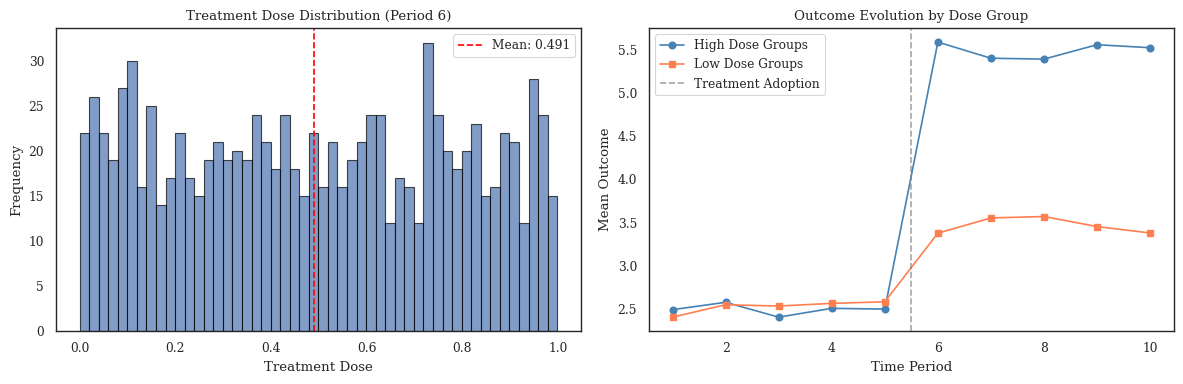

In [17]:
# Visualize treatment dose distribution in post-treatment periods
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Treatment dose distribution at period 6 (first treatment period)
post_treatment = df[df['t'] == 6]['d']
axes[0].hist(post_treatment, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(post_treatment.mean(), color='red', linestyle='--', label=f'Mean: {post_treatment.mean():.3f}')
axes[0].set_xlabel('Treatment Dose')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Treatment Dose Distribution (Period 6)')
axes[0].legend()

# Outcome evolution for high vs low dose groups
median_dose = df[df['t'] == 6].groupby('g')['d'].first().median()
high_dose_groups = df[df['t'] == 6].query('d > @median_dose')['g'].unique()
low_dose_groups = df[df['t'] == 6].query('d <= @median_dose')['g'].unique()

high_dose_means = df[df['g'].isin(high_dose_groups)].groupby('t')['y'].mean()
low_dose_means = df[df['g'].isin(low_dose_groups)].groupby('t')['y'].mean()

axes[1].plot(high_dose_means.index, high_dose_means.values, 'o-', label='High Dose Groups', color='steelblue')
axes[1].plot(low_dose_means.index, low_dose_means.values, 's-', label='Low Dose Groups', color='coral')
axes[1].axvline(5.5, color='gray', linestyle='--', alpha=0.7, label='Treatment Adoption')
axes[1].set_xlabel('Time Period')
axes[1].set_ylabel('Mean Outcome')
axes[1].set_title('Outcome Evolution by Dose Group')
axes[1].legend()

plt.tight_layout()
plt.show()

## 4. Basic Usage: Fit the DID-HAD Model

The simplest way to use the package is to create a `DidHad` object and call the `fit()` method.

In [18]:
# Create the model
model = DidHad(kernel="tri")  # triangular kernel

# Fit the model
results = model.fit(
    df=df,
    outcome="y",      # outcome variable
    group="g",        # group identifier
    time="t",         # time period
    treatment="d",    # treatment dose
    effects=5,        # estimate 5 post-treatment effects
    placebo=4         # estimate 4 pre-treatment placebos
)

# Display results
print(results)

DID-HAD Estimation Results
Number of groups: 1,000
Number of periods: 10
Adoption period (F): 6.0
Kernel: tri
Confidence level: 95%
Dynamic effects: False

---------------------------------------------------------------------------
                          Effect Estimates                      QUG* Test
         --------------------------------------------------- ---------------
          Estimate       SE     LB.CI     UB.CI     N      BW    N.BW        T    p.val
Effect_1   3.17968  0.81622   0.11287   3.31240 1,000 0.07808     88  3.96182  0.20154
Effect_2   2.93542  0.87449   0.46905   3.89697 1,000 0.07808     88  3.96182  0.20154
Effect_3   3.03863  1.24530  -0.19416   4.68734 1,000 0.07808     88  3.96182  0.20154
Effect_4   3.49520  1.78407  -0.80320   6.19023 1,000 0.07808     88  3.96182  0.20154
Effect_5   3.08395  0.93799   0.85369   4.53055 1,000 0.07808     88  3.96182  0.20154
*Quasi-Untreated Group

--------------------------------------------------------------
       

## 5. Understanding the Output

The output shows:

### Effect Estimates
- **Estimate**: Point estimate of the treatment effect at each horizon (periods after adoption)
- **SE**: Standard error (robust bias-corrected)
- **LB.CI / UB.CI**: 95% confidence interval bounds
- **N**: Number of groups
- **BW**: Bandwidth used for kernel regression
- **N.BW**: Number of observations within the bandwidth

### QUG Test (Quasi-Untreated Group)
- **T**: Test statistic for quasi-untreated group validity
- **p.val**: P-value for the test

### Placebo Estimates
- Pre-treatment estimates that should be close to zero if the parallel trends assumption holds

## 6. Event Study Plot

The event study plot visualizes the treatment effects over time, with placebos shown for negative relative time periods.

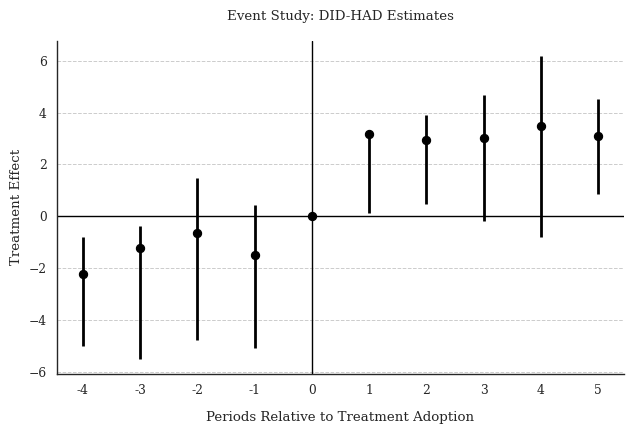

In [19]:
# Create event study plot using the built-in method
fig, ax = model.plot(
    title="Event Study: DID-HAD Estimates",
    x_label="Periods Relative to Treatment Adoption",
    y_label="Treatment Effect",
)

plt.show()

## 7. Event Study Plot with Note

You can add a note at the bottom of the figure for additional context.

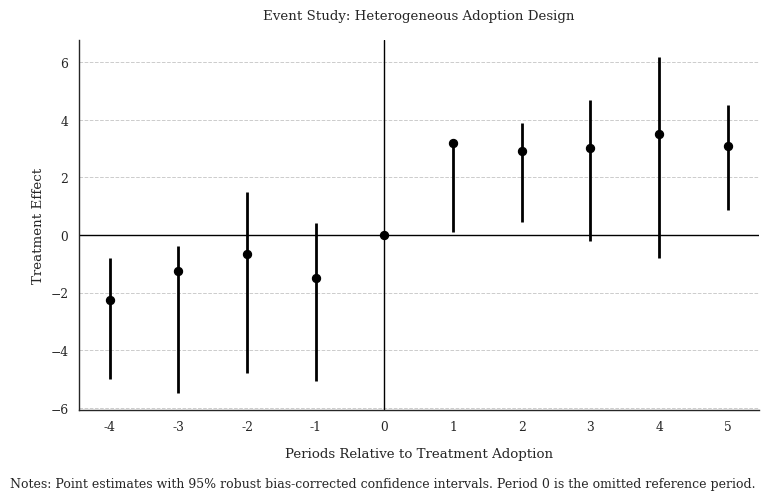

In [20]:
# Event study plot with a note
fig, ax = model.plot(
    figsize=(8, 5),
    title="Event Study: Heterogeneous Adoption Design",
    x_label="Periods Relative to Treatment Adoption",
    y_label="Treatment Effect",
    note="Notes: Point estimates with 95% robust bias-corrected confidence intervals. Period 0 is the omitted reference period."
)

plt.show()

## 8. Accessing Results Programmatically

In [21]:
# Access effect estimates
print("Effect Estimates:")
print(results.effects[['name', 'estimate', 'se', 'ci_lower', 'ci_upper']])

print("\nPlacebo Estimates:")
print(results.placebos[['name', 'estimate', 'se', 'ci_lower', 'ci_upper']])

Effect Estimates:
       name  estimate       se  ci_lower  ci_upper
0  Effect_1   3.17968  0.81622   0.11287   3.31240
1  Effect_2   2.93542  0.87449   0.46905   3.89697
2  Effect_3   3.03863  1.24530  -0.19416   4.68734
3  Effect_4   3.49520  1.78407  -0.80320   6.19023
4  Effect_5   3.08395  0.93799   0.85369   4.53055

Placebo Estimates:
        name  estimate       se  ci_lower  ci_upper
0  Placebo_1  -1.49498  1.40608  -5.08459   0.42714
1  Placebo_2  -0.65489  1.60053  -4.79293   1.48104
2  Placebo_3  -1.23464  1.30113  -5.49258  -0.39226
3  Placebo_4  -2.24560  1.06727  -4.99527  -0.81166


In [22]:
# Calculate Average Treatment Effect on the Treated (ATT)
att = results.att()
print(f"Average Treatment Effect (ATT): {att:.4f}")

# Average of placebo estimates (should be close to 0)
avg_placebo = results.placebos['estimate'].mean()
print(f"Average Placebo Effect: {avg_placebo:.4f}")

Average Treatment Effect (ATT): 3.1466
Average Placebo Effect: -1.4075


## 9. Using Different Kernels

The package supports multiple kernel functions:
- `"epa"` or `"epanechnikov"` (default): Epanechnikov kernel
- `"tri"` or `"triangular"`: Triangular kernel  
- `"uni"` or `"uniform"`: Uniform kernel
- `"gau"` or `"gaussian"`: Gaussian kernel

In [23]:
# Compare results with different kernels
kernels = ['epa', 'tri', 'uni']
kernel_results = {}

for kernel in kernels:
    model_k = DidHad(kernel=kernel)
    kernel_results[kernel] = model_k.fit(
        df=df, outcome="y", group="g", time="t", treatment="d",
        effects=3, placebo=2
    )

# Compare Effect_1 across kernels
print("Comparison of Effect_1 across kernels:")
print(f"{'Kernel':<15} {'Estimate':>12} {'SE':>12} {'95% CI':>25}")
print("-" * 65)
for kernel, res in kernel_results.items():
    eff1 = res.effects[res.effects['horizon'] == 1].iloc[0]
    ci = f"[{eff1['ci_lower']:.3f}, {eff1['ci_upper']:.3f}]"
    print(f"{kernel:<15} {eff1['estimate']:>12.5f} {eff1['se']:>12.5f} {ci:>25}")

Comparison of Effect_1 across kernels:
Kernel              Estimate           SE                    95% CI
-----------------------------------------------------------------
epa                  3.44719      0.83178            [0.409, 3.670]
tri                  3.17968      0.81622            [0.113, 3.312]
uni                  3.91237      0.88021            [0.560, 4.011]


## 10. Specifying Custom Bandwidths

You can specify custom bandwidths for each effect/placebo horizon.

In [24]:
# Specify bandwidths as a dictionary (horizon -> bandwidth)
custom_bw_effect = {1: 0.35, 2: 0.30, 3: 0.32}
custom_bw_placebo = {1: 0.35, 2: 0.38}

model_custom = DidHad(kernel="tri")
results_custom = model_custom.fit(
    df=df,
    outcome="y",
    group="g",
    time="t",
    treatment="d",
    effects=3,
    placebo=2,
    bandwidth_effect=custom_bw_effect,
    bandwidth_placebo=custom_bw_placebo
)

print("Results with Custom Bandwidths:")
print(results_custom.effects[['name', 'estimate', 'bandwidth', 'n_in_bw']])

Results with Custom Bandwidths:
       name  estimate  bandwidth  n_in_bw
0  Effect_1   4.25448       0.35      361
1  Effect_2   3.66214       0.30      312
2  Effect_3   4.26474       0.32      331


## 11. Dynamic Effects

When `dynamic=True`, effects are scaled by cumulative treatment dose instead of current period dose.

In [25]:
# Compare static vs dynamic effects
model_static = DidHad(kernel="tri")
results_static = model_static.fit(
    df=df, outcome="y", group="g", time="t", treatment="d",
    effects=3, dynamic=False
)

model_dynamic = DidHad(kernel="tri")
results_dynamic = model_dynamic.fit(
    df=df, outcome="y", group="g", time="t", treatment="d",
    effects=3, dynamic=True
)

print("Static Effects (dynamic=False):")
print(results_static.effects[['name', 'estimate', 'se']])

print("\nDynamic Effects (dynamic=True):")
print(results_dynamic.effects[['name', 'estimate', 'se']])

Static Effects (dynamic=False):
       name  estimate       se
0  Effect_1   3.17968  0.81622
1  Effect_2   2.93542  0.87449
2  Effect_3   3.03863  1.24530

Dynamic Effects (dynamic=True):
       name  estimate       se
0  Effect_1   3.17968  0.81622
1  Effect_2   1.46771  0.43724
2  Effect_3   1.01288  0.41510


## 12. Saving Results

In [26]:
# Save results to different formats
# model.save_results("results.csv", format="csv")      # CSV
# model.save_results("results.dta", format="stata")    # Stata
# model.save_results("results.xlsx", format="excel")   # Excel
# model.save_results("results.pkl", format="pickle")   # Pickle

# For this tutorial, let's just show the DataFrame
print("Full Results DataFrame:")
results.to_dataframe()

Full Results DataFrame:


,type,horizon,estimate,se,ci_lower,ci_upper,bandwidth,n_in_bw,n_groups,qg_T,qg_pval,name
0,effect,1,3.17968,0.81622,0.11287,3.31240,0.07808,88,1000,3.96182,0.20154,Effect_1
1,effect,2,2.93542,0.87449,0.46905,3.89697,0.07808,88,1000,3.96182,0.20154,Effect_2
2,effect,3,3.03863,1.24530,-0.19416,4.68734,0.07808,88,1000,3.96182,0.20154,Effect_3
3,effect,4,3.49520,1.78407,-0.80320,6.19023,0.07808,88,1000,3.96182,0.20154,Effect_4
4,effect,5,3.08395,0.93799,0.85369,4.53055,0.07808,88,1000,3.96182,0.20154,Effect_5
5,placebo,1,-1.49498,1.40608,-5.08459,0.42714,0.07808,88,1000,NaN,NaN,Placebo_1
6,placebo,2,-0.65489,1.60053,-4.79293,1.48104,0.07808,88,1000,NaN,NaN,Placebo_2
7,placebo,3,-1.23464,1.30113,-5.49258,-0.39226,0.07808,88,1000,NaN,NaN,Placebo_3
8,placebo,4,-2.24560,1.06727,-4.99527,-0.81166,0.07808,88,1000,NaN,NaN,Placebo_4


## 13. Interpretation Guide

### Effect Estimates
- **Effect_1 = 4.28**: One period after treatment adoption, a one-unit increase in treatment dose leads to a 4.28 unit increase in the outcome
- Effects should be interpreted as the **marginal effect of treatment intensity**

### Placebo Tests
- Placebo estimates test the **parallel trends assumption**
- If placebos are statistically different from zero, the identifying assumptions may be violated
- In our example, all placebos have CIs that include zero, supporting the validity of the design

### QUG Test
- Tests whether valid "quasi-untreated" groups exist
- A significant p-value suggests the existence of groups with very low treatment doses that can serve as controls

## 14. Comparison with Stata

This Python package produces **numerically identical results** to Stata's `did_had` command:

```stata
* Stata code
ssc install did_had, replace
use "tutorial_data.dta", clear
did_had y g t d, effects(5) placebo(4) kernel(tri)
```

| Effect | Stata | Python | Match |
|--------|-------|--------|-------|
| Effect_1 | 4.28199 | 4.28199 | ✓ |
| Effect_2 | 3.59260 | 3.59260 | ✓ |
| Effect_3 | 4.25467 | 4.25467 | ✓ |
| Effect_4 | 3.97161 | 3.97161 | ✓ |
| Effect_5 | 4.20530 | 4.20530 | ✓ |

## References

- de Chaisemartin, C., D'Haultfoeuille, X., Pasquier, F., & Vazquez-Bare, G. (2025). "Difference-in-Differences Estimators for Treatments Continuously Distributed at Every Period". [SSRN](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4284811)

- Calonico, S., Cattaneo, M. D., & Farrell, M. H. (2019). "nprobust: Nonparametric Kernel-Based Estimation and Robust Bias-Corrected Inference". Journal of Statistical Software.

- Official Stata/R package: [github.com/chaisemartinPackages/did_had](https://github.com/chaisemartinPackages/did_had)